# Advanced examples of `gmdh` module using

## Imports

In [1]:
import gmdh

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import datetime
import warnings

warnings.simplefilter('ignore')

## Supportive functions

In [2]:
def adfuller_test(ts):
    res = adfuller(ts)
    print('Dickey-Fuller test\n')
    print(f'statistic: {res[0]}')
    print(f'p-value: {res[1]}')
    print(f'\ncritical values')
    print(f'10%: {res[4]["10%"]}')
    print(f'5%: {res[4]["5%"]}')
    print(f'1%: {res[4]["1%"]}')

def print_metrics(y_test, y_pred, squared=False):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    crit_name = "MSE" if squared else "RMSE"
    print(f"{crit_name}: {mean_squared_error(y_test, y_pred, squared=squared)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

def get_predicted(model, lags):
  if lags > 1:
    return scaler.inverse_transform(model.predict(x_test[0], lags=lags).reshape(-1, 1))
  else:
    return scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))

def show_all_plot(y_pred):
  plt.figure(figsize=(16, 4))
  if needDiff:
    sns.lineplot(y=data.diff().dropna(), x=range(data.shape[0]-1), label='real')
  else:
    sns.lineplot(y=data, x=range(data.shape[0]), label='real')
  sns.lineplot(y=y_pred.flatten(), x=range(y_train.shape[0]+lags, y_train.shape[0] + len(y_pred) + lags), label='pred');

def show_part_plot(y_pred, nFirstPreds=365):
  plt.figure(figsize=(16, 4))
  sns.lineplot(y=scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()[:nFirstPreds], x=range(nFirstPreds), label='real')
  sns.lineplot(y=y_pred.flatten()[:nFirstPreds], x=range(nFirstPreds), label='pred')

def show_metric_for(y_pred, n=365):
  print_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()[:n], y_pred[:n])

# Regression task

## Laptops data preparation

In [3]:
laptop_data = pd.read_csv("laptop_price.csv", index_col=[0])
laptop_data.head()

,Company,Product,TypeName,Inches,Ram_GB,OpSys,Weight_kg,Price_euros,Touchscreen,ScreenWidth,...,Cpu_producer,Cpu_series,Cpu_model,Cpu_GHz,Gpu_producer,Gpu_model,Gpu_series,Memory1_GB,Memory1_type,Memory2_type
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,0,2560,...,Intel,-,Core i5,2.3,Intel,Iris Plus Graphics,640,128,SSD,-
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,0,1440,...,Intel,-,Core i5,1.8,Intel,HD Graphics,6000,128,Flash Storage,-
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,0,1920,...,Intel,7200U,Core i5,2.5,Intel,HD Graphics,620,256,SSD,-
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,0,2880,...,Intel,-,Core i7,2.7,AMD,Radeon Pro,455,512,SSD,-
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,0,2560,...,Intel,-,Core i5,3.1,Intel,Iris Plus Graphics,650,256,SSD,-


In [4]:
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244 entries, 0 to 1244
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1244 non-null   object 
 1   Product       1244 non-null   object 
 2   TypeName      1244 non-null   object 
 3   Inches        1244 non-null   float64
 4   Ram_GB        1244 non-null   int64  
 5   OpSys         1244 non-null   object 
 6   Weight_kg     1244 non-null   float64
 7   Price_euros   1244 non-null   float64
 8   Touchscreen   1244 non-null   int64  
 9   ScreenWidth   1244 non-null   int64  
 10  ScreenHeight  1244 non-null   int64  
 11  Cpu_producer  1244 non-null   object 
 12  Cpu_series    1244 non-null   object 
 13  Cpu_model     1244 non-null   object 
 14  Cpu_GHz       1244 non-null   float64
 15  Gpu_producer  1244 non-null   object 
 16  Gpu_model     1244 non-null   object 
 17  Gpu_series    1244 non-null   object 
 18  Memory1_GB    1244 non-null   int

In [5]:
category_cols = laptop_data.columns[laptop_data.dtypes == object]
laptop_data = pd.get_dummies(data=laptop_data.drop(category_cols, axis=1), columns=category_cols.drop(category_cols))
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244 entries, 0 to 1244
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Inches        1244 non-null   float64
 1   Ram_GB        1244 non-null   int64  
 2   Weight_kg     1244 non-null   float64
 3   Price_euros   1244 non-null   float64
 4   Touchscreen   1244 non-null   int64  
 5   ScreenWidth   1244 non-null   int64  
 6   ScreenHeight  1244 non-null   int64  
 7   Cpu_GHz       1244 non-null   float64
 8   Memory1_GB    1244 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 97.2 KB


In [6]:
laptop_x_train, laptop_x_test, laptop_y_train, laptop_y_test = \
    gmdh.split_data(laptop_data.drop(['Price_euros'], axis=1), laptop_data['Price_euros'], test_size=0.9)
laptop_scaler = MinMaxScaler().fit(laptop_x_train)
laptop_x_train = laptop_scaler.transform(laptop_x_train)
laptop_x_test = laptop_scaler.transform(laptop_x_test)
print("train elements:", laptop_x_train.shape[0], "\ntest elements:", laptop_x_test.shape[0])

train elements: 124 
test elements: 1120


## COMBI, MULTI, MIA, RIA

In [7]:
laptop_combi_model = gmdh.Combi()
laptop_combi_model.fit(laptop_x_train, laptop_y_train, verbose=1, n_jobs=-1, test_size=0.24, limit=0, 
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))
print()
print(laptop_combi_model.get_best_polynomial())
print()
laptop_y_pred_combi = laptop_combi_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_combi)

LEVEL 1  [=========================] 100% :00s] (8 combinations) error=3.53719e+06                                  
LEVEL 2  [=========================] 100% :00s] (28 combinations) error=2.67756e+06                                 
LEVEL 3  [=========================] 100% :00s] (56 combinations) error=2.55512e+06                                 
LEVEL 4  [=========================] 100% :00s] (70 combinations) error=2.5193e+06                                  
LEVEL 5  [=========================] 100% :00s] (56 combinations) error=2.44273e+06                                 
LEVEL 6  [=========================] 100% :00s] (28 combinations) error=2.51365e+06                                 

y = 1251.2011*x2 - 318.5661*x3 + 871.8101*x5 + 254.0321*x7 - 280.4694*x8 + 227.7081

R^2: 0.5808381501598769
RMSE: 461.5678789111761
MAE: 320.50084093380843


In [8]:
laptop_multi_model = gmdh.Multi()
laptop_multi_model.fit(laptop_x_train, laptop_y_train, verbose=1, n_jobs=-1, test_size=0.24, limit=0, k_best=5, 
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))
print()
print(laptop_multi_model.get_best_polynomial())
print()
laptop_y_pred_multi = laptop_multi_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_multi)

LEVEL 1  [=========================] 100% :00s] (8 combinations) error=3.53719e+06                                  
LEVEL 2  [=========================] 100% :00s] (25 combinations) error=2.67756e+06                                 
LEVEL 3  [=========================] 100% :00s] (20 combinations) error=2.55512e+06                                 
LEVEL 4  [=========================] 100% :00s] (19 combinations) error=2.5193e+06                                  
LEVEL 5  [=========================] 100% :00s] (13 combinations) error=2.44273e+06                                 
LEVEL 6  [=========================] 100% :00s] (10 combinations) error=2.51365e+06                                 

y = 1251.2011*x2 - 318.5661*x3 + 871.8101*x5 + 254.0321*x7 - 280.4694*x8 + 227.7081

R^2: 0.5808381501598769
RMSE: 461.5678789111761
MAE: 320.50084093380843


In [9]:
laptop_mia_model = gmdh.Mia()
laptop_mia_model.fit(laptop_x_train, laptop_y_train, verbose=1, n_jobs=-1, test_size=0.45, limit=0, k_best=9, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.SYM_REGULARITY), 
                     polynomial_type=gmdh.PolynomialType.LINEAR)
laptop_y_pred_mia = laptop_mia_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_mia)

LEVEL 1  [=========================] 100% :00s] (28 combinations) error=9.43877e+06                                 
LEVEL 2  [=========================] 100% :00s] (36 combinations) error=8.56622e+06                                 
LEVEL 3  [=========================] 100% :00s] (36 combinations) error=8.54476e+06                                 
LEVEL 4  [=========================] 100% :00s] (36 combinations) error=8.48132e+06                                 
LEVEL 5  [=========================] 100% :00s] (36 combinations) error=8.51104e+06                                 
R^2: 0.5473981187203197
RMSE: 479.6261807360983
MAE: 335.5253662928581


In [10]:
laptop_ria_model = gmdh.Ria()
laptop_ria_model.fit(laptop_x_train, laptop_y_train, verbose=1, n_jobs=-1, test_size=0.52, limit=0, k_best=7, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY),
                     polynomial_type=gmdh.PolynomialType.LINEAR)
laptop_y_pred_ria = laptop_ria_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_ria)

LEVEL 1  [=========================] 100% :00s] (28 combinations) error=5.7286e+06                                  
LEVEL 2  [=========================] 100% :00s] (56 combinations) error=5.19012e+06                                 
LEVEL 3  [=========================] 100% :00s] (56 combinations) error=5.03805e+06                                 
LEVEL 4  [=========================] 100% :00s] (56 combinations) error=5.03805e+06                                 
LEVEL 5  [=========================] 100% :00s] (56 combinations) error=5.03805e+06                                 
LEVEL 6  [=========================] 100% :00s] (56 combinations) error=5.03805e+06                                 
R^2: 0.5626051899060046
RMSE: 471.49980422922533
MAE: 329.78396653179


## LinearRegression, RandomForestRegressor, GradientBoostingRegressor

In [11]:
laptop_linear_model = LinearRegression()
laptop_linear_model.fit(laptop_x_train, laptop_y_train)
laptop_y_pred_linear = laptop_linear_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_linear)

R^2: 0.5166897938667493
RMSE: 495.63011546026536
MAE: 335.9187752412349


In [12]:
laptop_forest_model = RandomForestRegressor(random_state=17)
laptop_forest_model.fit(laptop_x_train, laptop_y_train)
laptop_y_pred_forest = laptop_forest_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_forest)

R^2: 0.5531609937485031
RMSE: 476.5629139408306
MAE: 315.6540405463435


In [13]:
laptop_boosting_model = GradientBoostingRegressor(random_state=17)
laptop_boosting_model.fit(laptop_x_train, laptop_y_train)
laptop_y_pred_boosting = laptop_boosting_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_boosting)

R^2: 0.5580109251872696
RMSE: 473.9695824232097
MAE: 305.499915904733


## Results comparison

In [14]:
print('linear')
print_metrics(laptop_y_test, laptop_y_pred_linear)
print('\ncombi')
print_metrics(laptop_y_test, laptop_y_pred_combi)
print('\nmulti')
print_metrics(laptop_y_test, laptop_y_pred_multi)
print('\nmia')
print_metrics(laptop_y_test, laptop_y_pred_mia)
print('\nria')
print_metrics(laptop_y_test, laptop_y_pred_ria)
print('\nforest')
print_metrics(laptop_y_test, laptop_y_pred_forest)
print('\nboosting')
print_metrics(laptop_y_test, laptop_y_pred_boosting)

linear
R^2: 0.5166897938667493
RMSE: 495.63011546026536
MAE: 335.9187752412349

combi
R^2: 0.5808381501598769
RMSE: 461.5678789111761
MAE: 320.50084093380843

multi
R^2: 0.5808381501598769
RMSE: 461.5678789111761
MAE: 320.50084093380843

mia
R^2: 0.5473981187203197
RMSE: 479.6261807360983
MAE: 335.5253662928581

ria
R^2: 0.5626051899060046
RMSE: 471.49980422922533
MAE: 329.78396653179

forest
R^2: 0.5531609937485031
RMSE: 476.5629139408306
MAE: 315.6540405463435

boosting
R^2: 0.5580109251872696
RMSE: 473.9695824232097
MAE: 305.499915904733


# Time series

## Weather data preparation

In [15]:
path = 'Madrid_Daily_Weather.csv'
data = pd.read_csv(path, index_col=[0])
data.head()

,CET,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2001-06-27,23.0,21.0,19.0,4.0,4.0,3.0,35.0,32.0,29.0,...,10.0,10.0,10.0,24,10,NaN,0.0,3.0,NaN,333
1,2001-06-28,29.0,21.0,13.0,7.0,4.0,1.0,67.0,35.0,16.0,...,NaN,NaN,NaN,13,6,NaN,0.0,NaN,NaN,16
2,2001-06-29,32.0,23.0,14.0,6.0,3.0,1.0,55.0,27.0,14.0,...,NaN,NaN,NaN,13,5,NaN,0.0,NaN,NaN,208
3,2001-06-30,35.0,26.0,16.0,8.0,4.0,2.0,45.0,26.0,13.0,...,NaN,NaN,NaN,13,5,NaN,0.0,NaN,NaN,13
4,2001-07-01,36.0,27.0,18.0,9.0,5.0,2.0,45.0,25.0,12.0,...,NaN,NaN,NaN,11,6,NaN,0.0,NaN,NaN,90


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5271 entries, 0 to 5270
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CET                          5271 non-null   object 
 1   Max TemperatureC             5271 non-null   float64
 2   Mean TemperatureC            5271 non-null   float64
 3   Min TemperatureC             5271 non-null   float64
 4   Dew PointC                   5271 non-null   float64
 5   MeanDew PointC               5271 non-null   float64
 6   Min DewpointC                5271 non-null   float64
 7   Max Humidity                 5271 non-null   float64
 8    Mean Humidity               5271 non-null   float64
 9    Min Humidity                5271 non-null   float64
 10   Max Sea Level PressurehPa   5271 non-null   int64  
 11   Mean Sea Level PressurehPa  5271 non-null   int64  
 12   Min Sea Level PressurehPa   5271 non-null   int64  
 13   Max VisibilityKm      

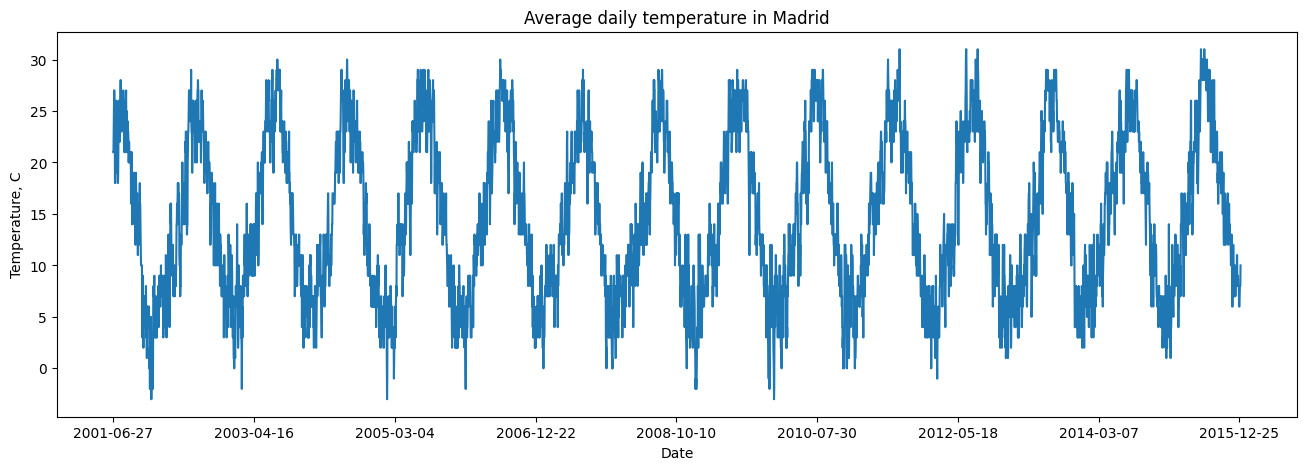

In [17]:
plt.figure(figsize=(16, 5))
plt.title("Average daily temperature in Madrid")
plt.xlabel("Date")
plt.ylabel("Temperature, С")
sns.lineplot(data=data, x='CET', y='Mean TemperatureC')
plt.xticks(range(0, data.shape[0], int(data.shape[0]/8)))
plt.show()

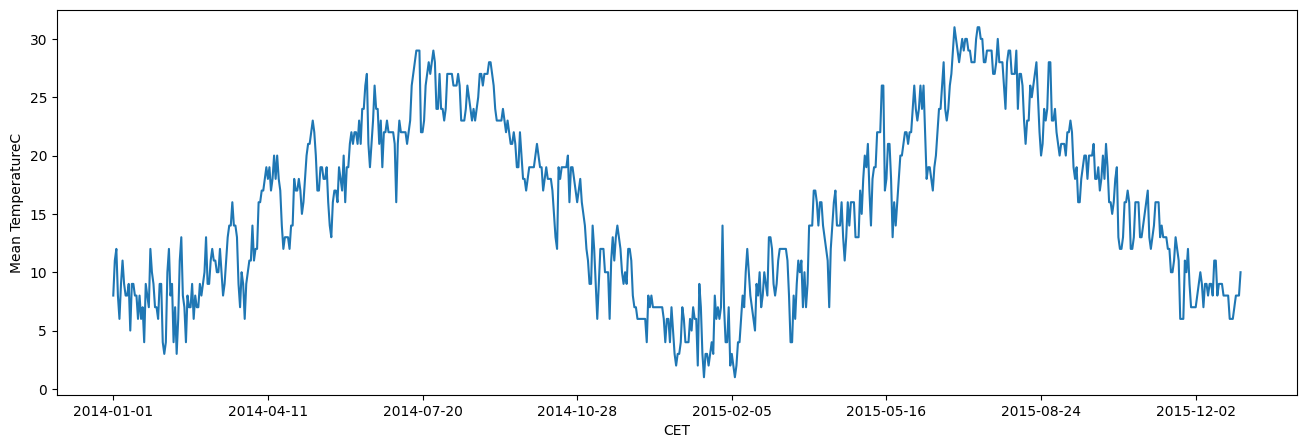

In [18]:
plt.figure(figsize=(16, 5))
sns.lineplot(data=data[-365*2:], x='CET', y='Mean TemperatureC')
plt.xticks(range(0, 365*2, 100))
plt.show()

In [19]:
data = data['Mean TemperatureC']

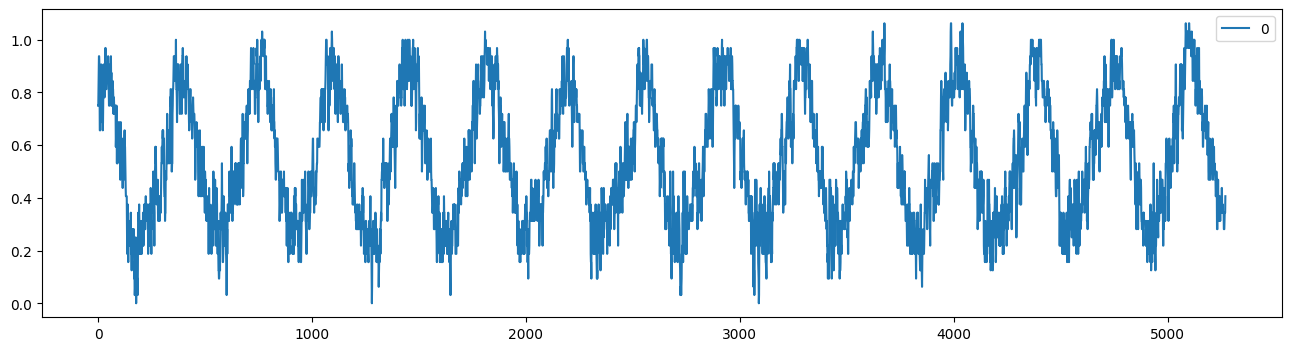

In [20]:
test_size = 0.9
scaler = MinMaxScaler()
lags = 90
needDiff = False


def prepare_data(data, lags, scaler, test_size):
  scaler.fit(data[:round(len(data) * (1-test_size))].values.reshape(-1, 1))
  scaled_data = scaler.transform(data.values.reshape(-1, 1))
  x, y = gmdh.time_series_transformation(scaled_data, lags=lags)
  x_train, x_test, y_train, y_test = gmdh.split_data(x, y, test_size=test_size)
  return scaled_data, x_train, x_test, y_train, y_test
  
if needDiff:
  scaled_data, x_train, x_test, y_train, y_test = prepare_data(data.diff().dropna(), lags, scaler, test_size)
  x, y = gmdh.time_series_transformation(data, lags=lags)
  y_test_nodiff = gmdh.split_data(x, y, test_size=test_size)[3][:] #[1:]
else:
  scaled_data, x_train, x_test, y_train, y_test = prepare_data(data, lags, scaler, test_size)
  y_test_nodiff = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(16, 4))
sns.lineplot(data=scaled_data);

In [21]:
print("train elements:", x_train.shape[0], "\ntest elements:", x_test.shape[0])

train elements: 518 
test elements: 4663


In [22]:
adfuller_test(data)

Dickey-Fuller test

statistic: -4.679761656535551
p-value: 9.183643485470715e-05

critical values
10%: -2.567063858387586
5%: -2.8620920545995907
1%: -3.4315992855005613


## RandomForestRegressor

In [23]:
forest_model = RandomForestRegressor(random_state=17, criterion='friedman_mse')
forest_model.fit(x_train, y_train);

In [24]:
lags_to_predict = 365

if lags_to_predict > 1:
  multistep_x_test_forest = list(list(x_test[:1])[0])
  y_pred_forest = []
  for i in range(lags_to_predict):
    pred = forest_model.predict(np.array(multistep_x_test_forest).reshape(1, -1))
    multistep_x_test_forest.append(pred[0])
    multistep_x_test_forest.pop(0)
    y_pred_forest.append(scaler.inverse_transform(np.array(pred).reshape(-1, 1))[0][0])
  y_pred_forest = np.array(y_pred_forest)
else:
  y_pred_forest = scaler.inverse_transform(forest_model.predict(x_test).reshape(-1, 1))

R^2: -0.7233592841364462
RMSE: 9.788537411561252
MAE: 7.841534246575342


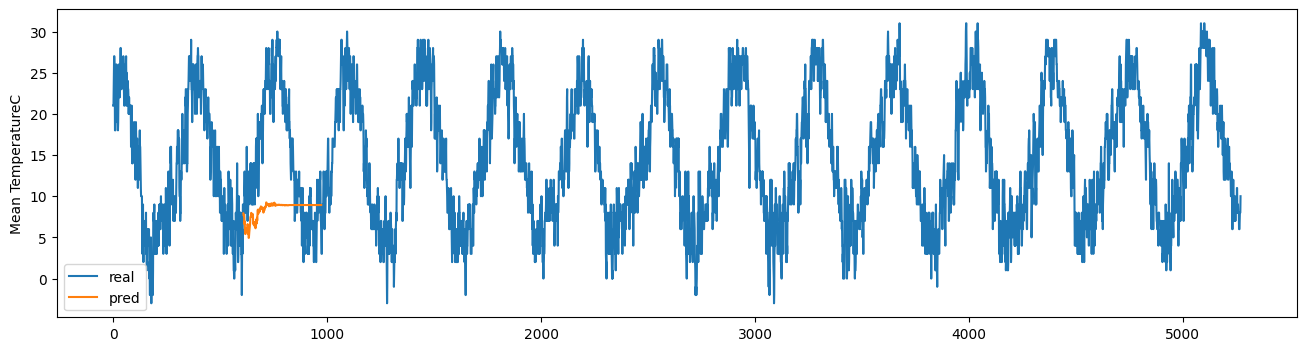

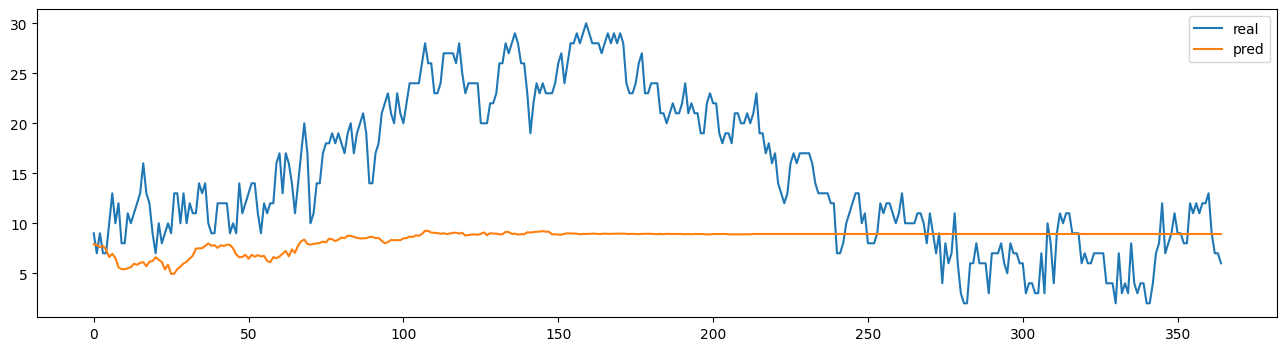

In [25]:
show_all_plot(y_pred_forest)
show_part_plot(y_pred_forest)
show_metric_for(y_pred_forest)

## GradientBoostingRegressor

In [26]:
boosting_model = GradientBoostingRegressor(random_state=17, learning_rate=0.5, loss='absolute_error', min_samples_split=10)
boosting_model.fit(x_train, y_train);

In [27]:
lags_to_predict = 365

if lags_to_predict > 1:
  multistep_x_test_boosting = list(list(x_test[:1])[0])
  y_pred_boosting = []
  for i in range(lags_to_predict):
    pred = boosting_model.predict(np.array(multistep_x_test_boosting).reshape(1, -1))
    multistep_x_test_boosting.append(pred[0])
    multistep_x_test_boosting.pop(0)
    y_pred_boosting.append(scaler.inverse_transform(np.array(pred).reshape(-1, 1))[0][0])
  y_pred_boosting = np.array(y_pred_boosting)
else:
  y_pred_boosting = scaler.inverse_transform(boosting_model.predict(x_test).reshape(-1, 1))

R^2: -0.4316033747385446
RMSE: 8.921569184950945
MAE: 7.136753093634463


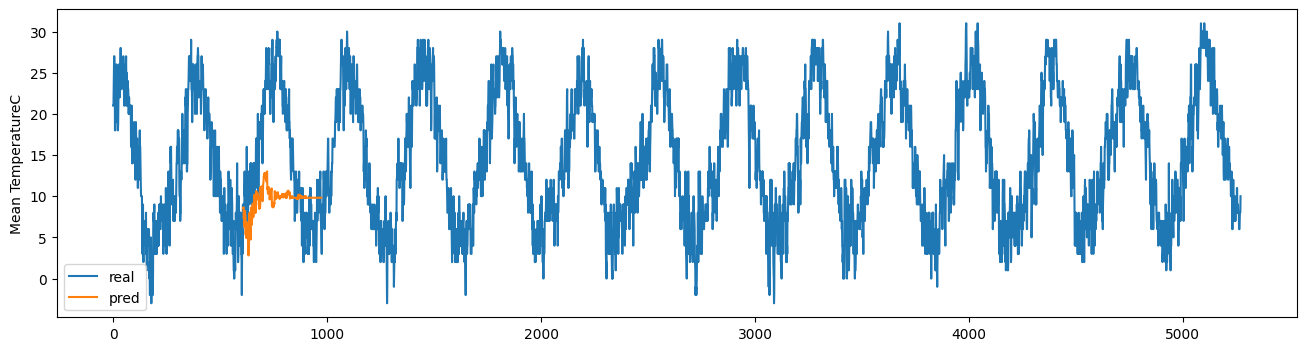

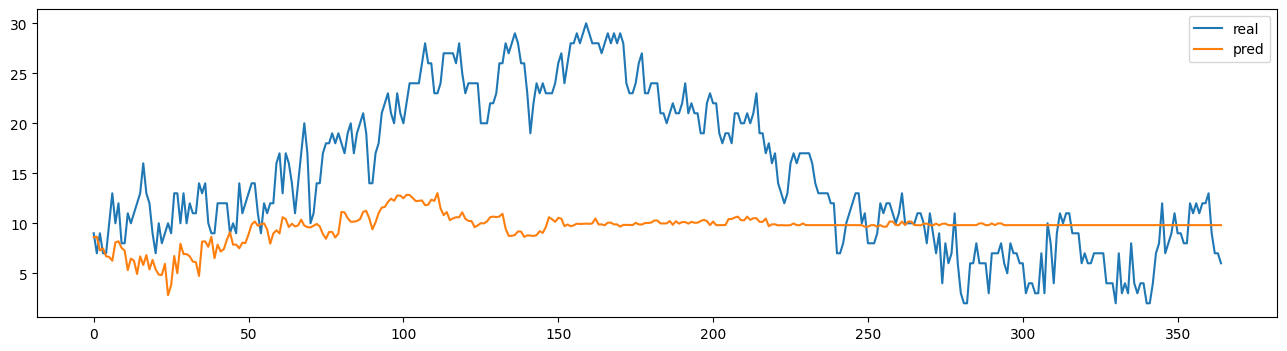

In [28]:
show_all_plot(y_pred_boosting)
show_part_plot(y_pred_boosting)
show_metric_for(y_pred_boosting)

## LSTM

In [29]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(lags, 1), return_sequences=True))
lstm_model.add(LSTM(units=10, input_shape=(lags, 1), return_sequences=False))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [30]:
x_train_lstm = x_train.reshape(-1, lags, 1)
y_train_lstm = y_train.reshape(-1, 1)

x_test_lstm = x_test.reshape(-1, lags, 1)
y_test_lstm = y_test.reshape(-1, 1)

In [31]:
%%time
epochs = 10

history = lstm_model.fit(x_train_lstm, y_train_lstm, batch_size=250, epochs=epochs, validation_split=0.2, verbose=0)

CPU times: total: 19.4 s
Wall time: 10 s


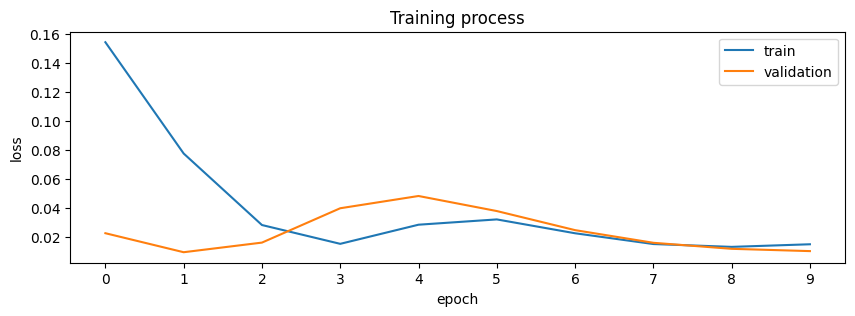

In [32]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=range(history.params['epochs']), y=history.history['loss'], label='train')
sns.lineplot(x=range(history.params['epochs']), y=history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(epochs))
plt.title('Training process');

In [33]:
lags_to_predict = 365

if lags_to_predict > 1:
  multistep_x_test_lstm = list(list(x_test_lstm[:1])[0])
  y_pred_lstm = []
  for i in range(lags_to_predict):
    pred = lstm_model.predict(np.array(multistep_x_test_lstm).reshape(-1, lags, 1), verbose=0)
    multistep_x_test_lstm.append(pred[0])
    multistep_x_test_lstm.pop(0)
    y_pred_lstm.append(scaler.inverse_transform(pred)[0][0])
  y_pred_lstm = np.array(y_pred_lstm)
else:
  y_pred_lstm = scaler.inverse_transform(lstm_model.predict(x_test_lstm))

R^2: -0.7009692707520634
RMSE: 9.724742821131317
MAE: 7.6846648203183525


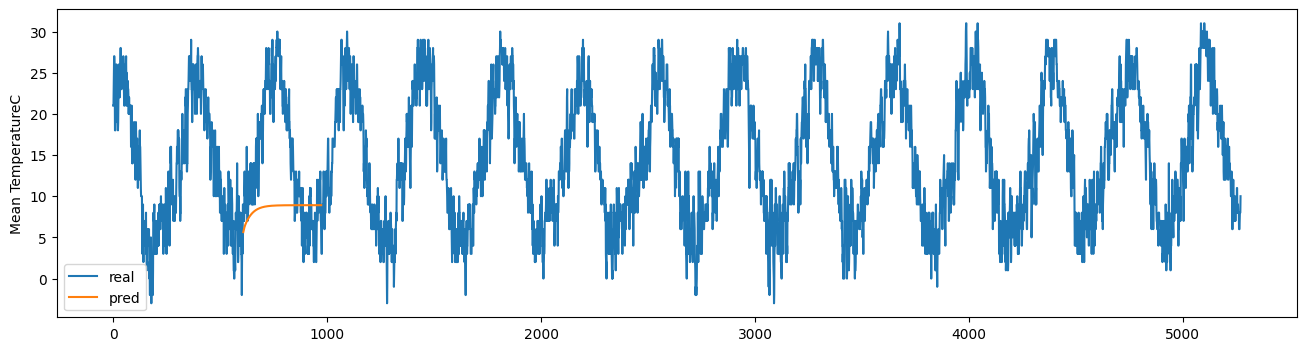

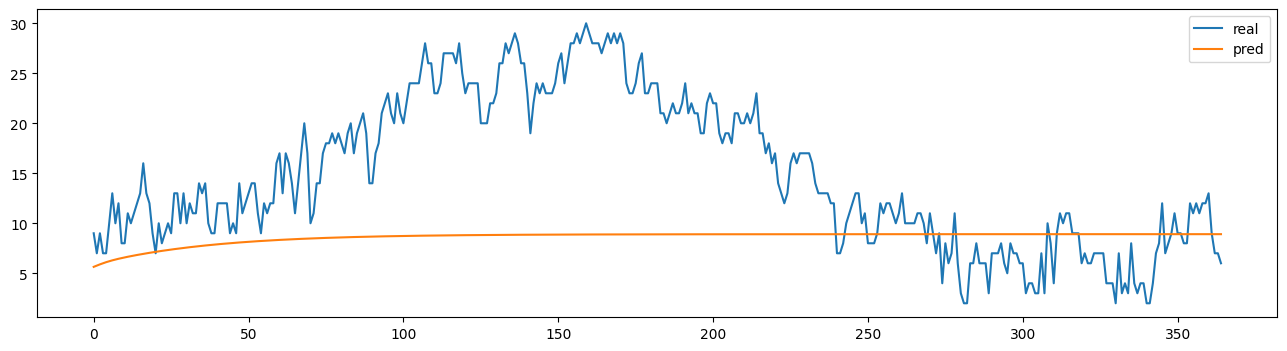

In [34]:
show_all_plot(y_pred_lstm)
show_part_plot(y_pred_lstm)
show_metric_for(y_pred_lstm)

## Multi

In [35]:
multi_model = gmdh.Multi()
multi_model.fit(x_train, y_train, criterion=gmdh.Criterion(criterion_type=gmdh.CriterionType.SYM_REGULARITY), 
                verbose=1, n_jobs=-1, k_best=4, limit=0);

LEVEL 1  [=========================] 100% :00s] (90 combinations) error=2.460664                                    
LEVEL 2  [=========================] 100% :00s] (350 combinations) error=2.31365                                    
LEVEL 3  [=========================] 100% :00s] (346 combinations) error=2.271083                                   
LEVEL 4  [=========================] 100% :00s] (342 combinations) error=2.224552                                   
LEVEL 5  [=========================] 100% :00s] (341 combinations) error=2.210985                                   
LEVEL 6  [=========================] 100% :00s] (334 combinations) error=2.20002                                    
LEVEL 7  [=========================] 100% :00s] (332 combinations) error=2.189581                                   
LEVEL 8  [=========================] 100% :00s] (328 combinations) error=2.180895                                   
LEVEL 9  [=========================] 100% :00s] (326 combination

R^2: 0.21554020734811963
RMSE: 6.604124248065769
MAE: 5.32876059658102


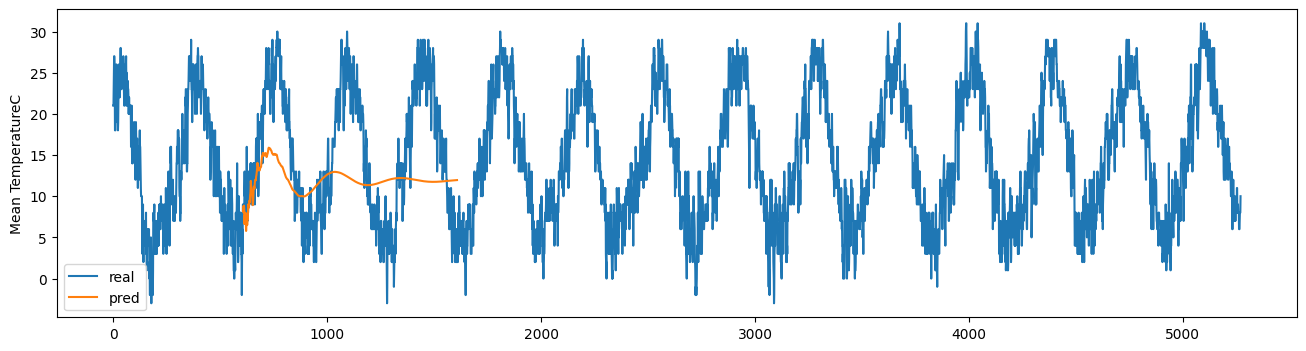

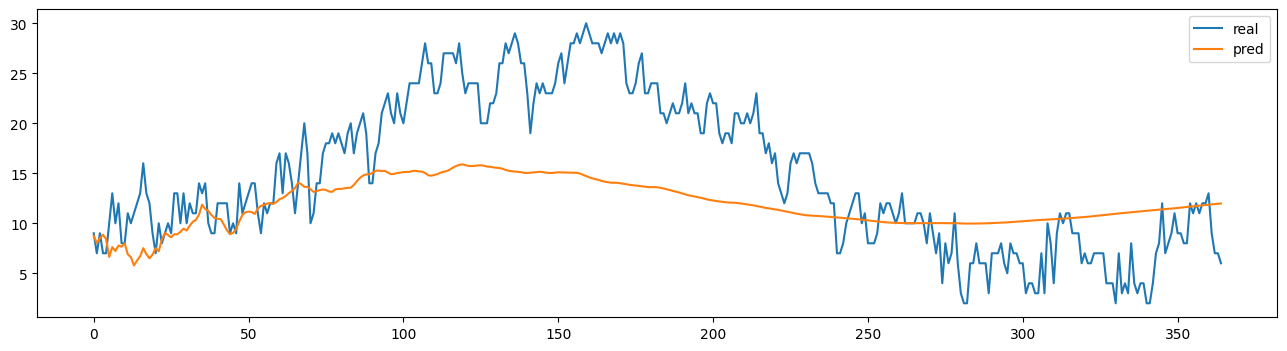

In [36]:
lags_to_predict = 1000

y_pred_multi = get_predicted(multi_model, lags_to_predict)
show_all_plot(y_pred_multi)
show_part_plot(y_pred_multi)
show_metric_for(y_pred_multi)

## Mia

In [37]:
mia_model = gmdh.Mia()
mia_model.fit(x_train, y_train, polynomial_type=gmdh.PolynomialType.LINEAR, 
              criterion=gmdh.Criterion(criterion_type=gmdh.CriterionType.SYM_REGULARITY), 
              verbose=1, n_jobs=-1, k_best=20, limit=0.01);

LEVEL 1  [=========================] 100% :00s] (4005 combinations) error=2.31365                                   
LEVEL 2  [=========================] 100% :00s] (190 combinations) error=2.290807                                   
LEVEL 3  [=========================] 100% :00s] (190 combinations) error=2.290714                                   


R^2: -0.4982839520057154
RMSE: 9.126976974174216
MAE: 7.175856807726612


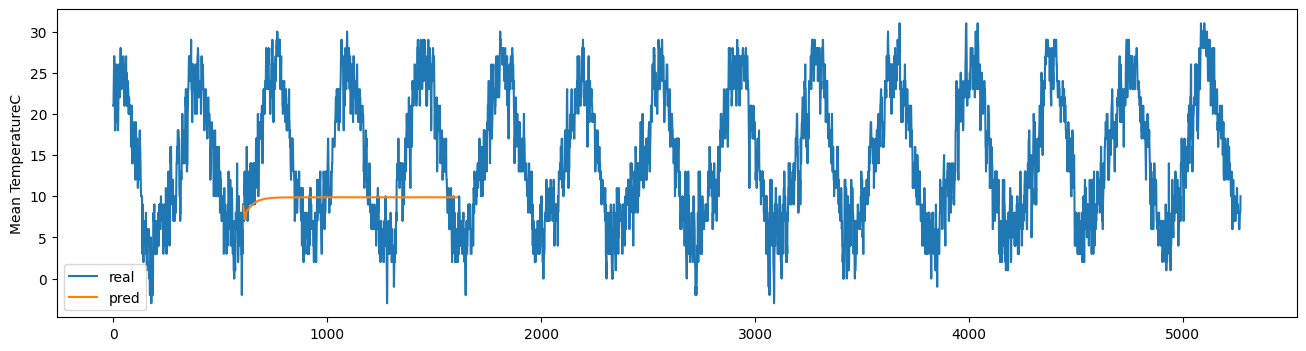

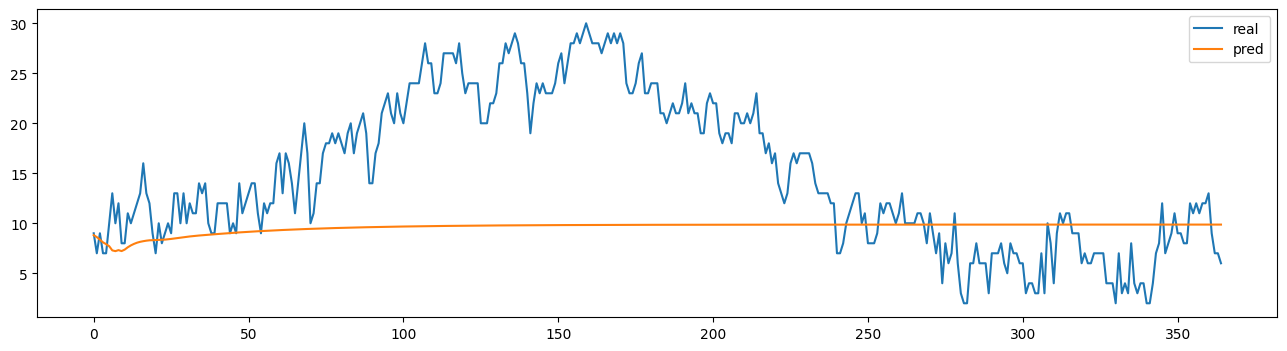

In [38]:
lags_to_predict = 1000

y_pred_mia = get_predicted(mia_model, lags_to_predict)
show_all_plot(y_pred_mia)
show_part_plot(y_pred_mia)
show_metric_for(y_pred_mia)

## RIA

In [39]:
ria_model = gmdh.Ria()
ria_model.fit(x_train, y_train, polynomial_type=gmdh.PolynomialType.LINEAR, 
              criterion=gmdh.Criterion(criterion_type=gmdh.CriterionType.SYM_STABILITY),
              verbose=1, n_jobs=-1, k_best=10, limit=0.0001);

LEVEL 1  [=========================] 100% :00s] (4005 combinations) error=4.566576                                  
LEVEL 2  [=========================] 100% :00s] (900 combinations) error=4.493977                                   
LEVEL 3  [=========================] 100% :00s] (900 combinations) error=4.407633                                   
LEVEL 4  [=========================] 100% :00s] (900 combinations) error=4.325532                                   
LEVEL 5  [=========================] 100% :00s] (900 combinations) error=4.293191                                   
LEVEL 6  [=========================] 100% :00s] (900 combinations) error=4.27372                                    
LEVEL 7  [=========================] 100% :00s] (900 combinations) error=4.264181                                   
LEVEL 8  [=========================] 100% :00s] (900 combinations) error=4.233698                                   
LEVEL 9  [=========================] 100% :00s] (900 combination

R^2: 0.26202789516033254
RMSE: 6.405453221316318
MAE: 5.202638960803123


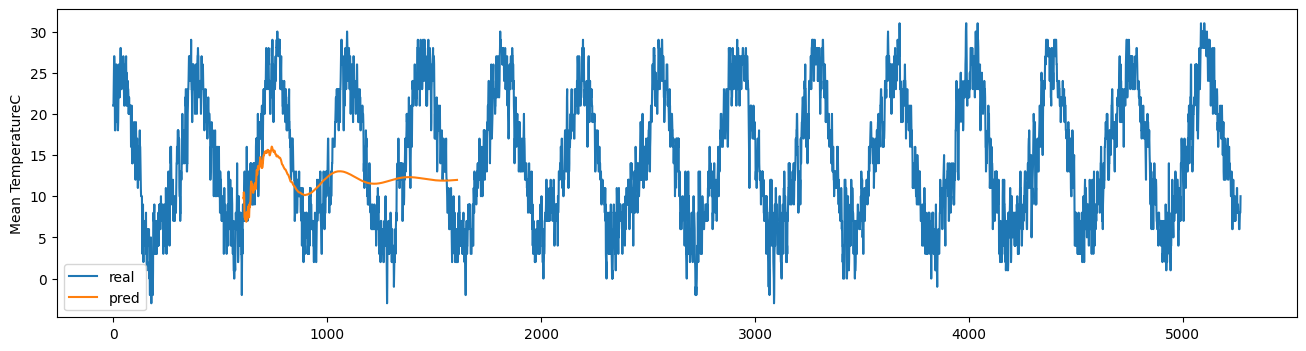

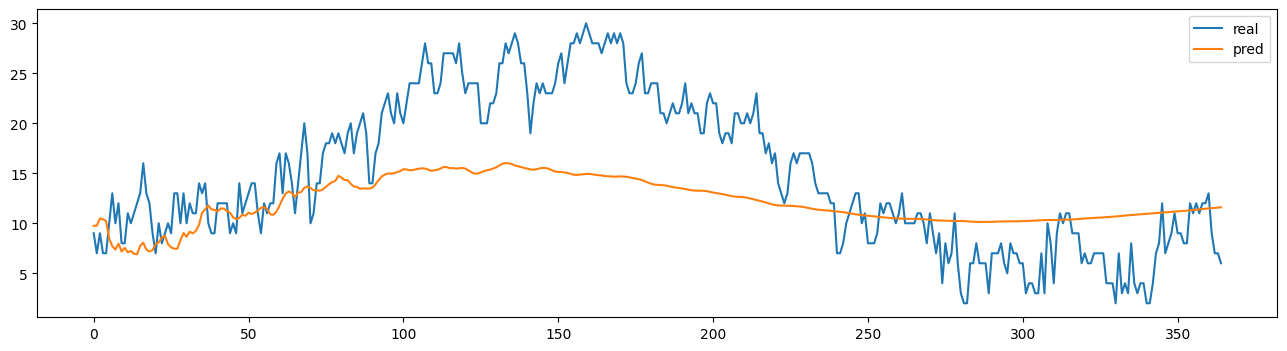

In [40]:
lags_to_predict = 1000

y_pred_ria = get_predicted(ria_model, lags_to_predict)
show_all_plot(y_pred_ria)
show_part_plot(y_pred_ria)
show_metric_for(y_pred_ria)

## Results comparison

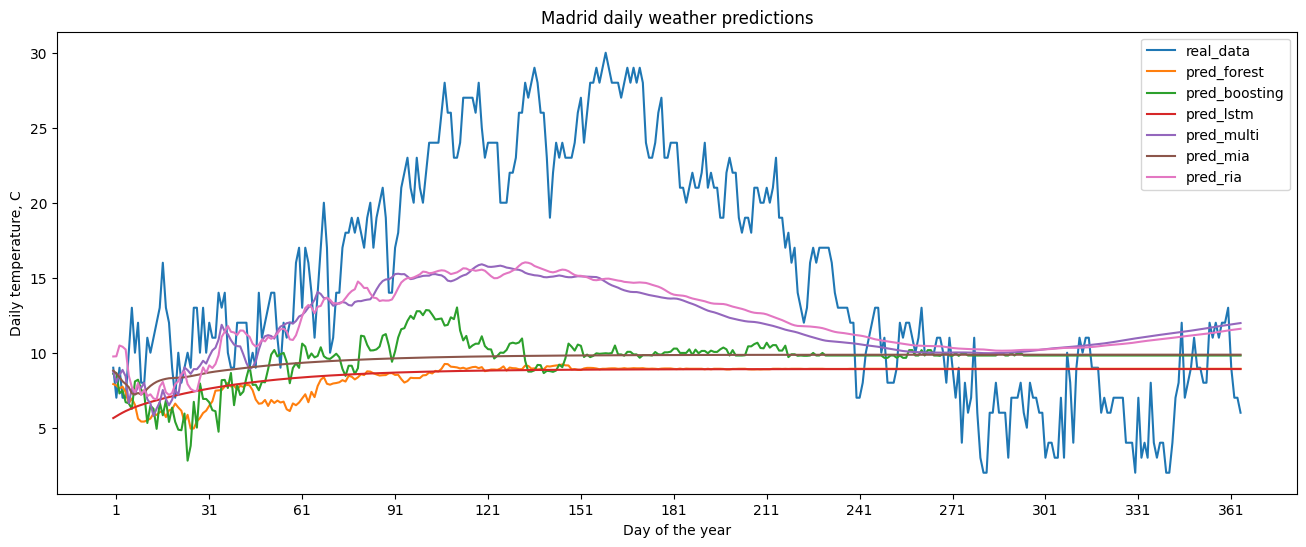

In [41]:
nFirstPreds = 365

plt.figure(figsize=(16, 6))
plt.title("Madrid daily weather predictions")
plt.xlabel("Day of the year")
plt.ylabel("Daily temperature, C")
plot = sns.lineplot(y=scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()[:nFirstPreds], 
                    x=range(nFirstPreds), label='real_data', linewidth=1.5)
sns.lineplot(y=(y_pred_forest.flatten()[:nFirstPreds]), x=range(nFirstPreds), label='pred_forest')
sns.lineplot(y=(y_pred_boosting.flatten()[:nFirstPreds]), x=range(nFirstPreds), label='pred_boosting');
sns.lineplot(y=y_pred_lstm.flatten()[:nFirstPreds], x=range(nFirstPreds), label='pred_lstm')
sns.lineplot(y=(y_pred_multi.flatten()[:nFirstPreds]), x=range(nFirstPreds), label='pred_multi')
sns.lineplot(y=(y_pred_mia.flatten()[:nFirstPreds]), x=range(nFirstPreds), label='pred_mia')
sns.lineplot(y=(y_pred_ria.flatten()[:nFirstPreds]), x=range(nFirstPreds), label='pred_ria')
plot.set(xticks=np.arange(1,365,30));

In [42]:
print("forest")
show_metric_for(y_pred_forest)
print("\nboosting")
show_metric_for(y_pred_boosting)
print("\nlstm")
show_metric_for(y_pred_lstm)
print("\nmulti")
show_metric_for(y_pred_multi)
print("\nmia")
show_metric_for(y_pred_mia)
print("\nria")
show_metric_for(y_pred_ria)

forest
R^2: -0.7233592841364462
RMSE: 9.788537411561252
MAE: 7.841534246575342

boosting
R^2: -0.4316033747385446
RMSE: 8.921569184950945
MAE: 7.136753093634463

lstm
R^2: -0.7009692707520634
RMSE: 9.724742821131317
MAE: 7.6846648203183525

multi
R^2: 0.21554020734811963
RMSE: 6.604124248065769
MAE: 5.32876059658102

mia
R^2: -0.4982839520057154
RMSE: 9.126976974174216
MAE: 7.175856807726612

ria
R^2: 0.26202789516033254
RMSE: 6.405453221316318
MAE: 5.202638960803123
